In [2]:
# Cell 0: All required imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             accuracy_score, f1_score, precision_score, recall_score, roc_curve)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb

# Imbalance
from imblearn.over_sampling import SMOTE

# Save/load models
import joblib

# Optional heavy libs
TF_AVAILABLE = True
SHAP_AVAILABLE = True
try:
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense
except:
    TF_AVAILABLE = False

try:
    import shap
except:
    SHAP_AVAILABLE = False

np.random.seed(42)


In [3]:
# Cell 1: Dataset path and loading
DATA_PATH = r"D:\archive\creditcard.csv"  # <-- edit if needed

if not os.path.exists(DATA_PATH):
    print("Default path not found:", DATA_PATH)
    candidates = [os.path.join(os.getcwd(), "creditcard.csv")]
    for c in candidates:
        if os.path.exists(c):
            DATA_PATH = c
            break

print("Loading from:", DATA_PATH)
data = pd.read_csv(DATA_PATH)
print("Loaded. Shape:", data.shape)
print(data.head())
print("\nClass distribution:\n", data['Class'].value_counts())


Loading from: D:\archive\creditcard.csv
Loaded. Shape: (284807, 31)
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.79827

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21 

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.175161e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.384974e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.094852e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,1.021879e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.494498e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.620335e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.149614e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.414189e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


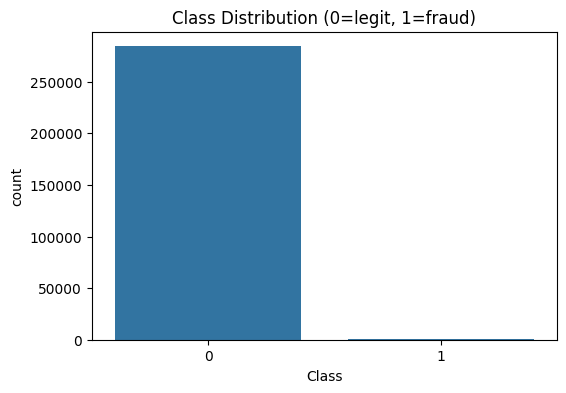

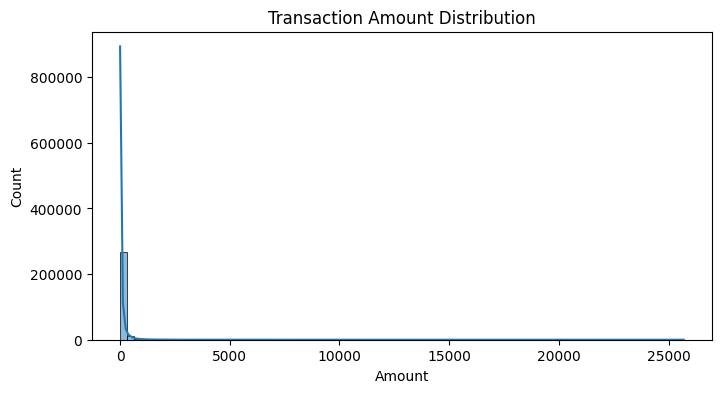

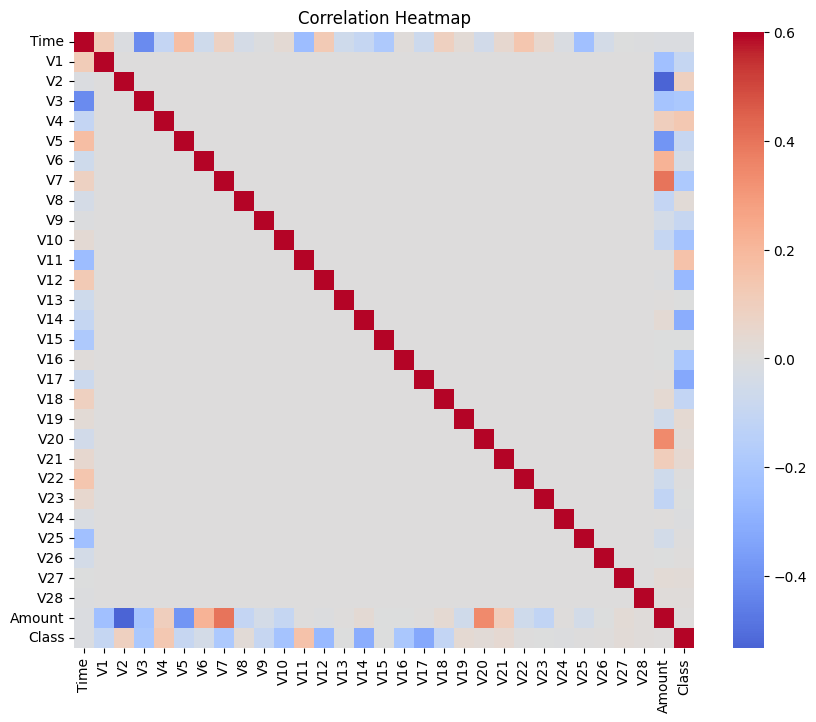

In [4]:
# Cell 2: EDA
print("Data info:")
print(data.info())

print("\nDescribe (numerical summary):")
display(data.describe().T)

# Class distribution plot
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title("Class Distribution (0=legit, 1=fraud)")
plt.show()

# Amount distribution
plt.figure(figsize=(8,4))
sns.histplot(data['Amount'], bins=80, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()

# Correlation heatmap (subset)
plt.figure(figsize=(10,8))
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, vmax=0.6)
plt.title("Correlation Heatmap")
plt.show()


In [5]:
# Cell 3: Preprocessing & scaling
df = data.copy()
scaler = StandardScaler()
df[['Time','Amount']] = scaler.fit_transform(df[['Time','Amount']])

# Features and target
X = df.drop('Class', axis=1)
y = df['Class']

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (284807, 30) y shape: (284807,)


In [6]:
# Cell 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set:", X_train.shape, "Test set:", X_test.shape)
print("Train class dist:\n", y_train.value_counts())
print("Test class dist:\n", y_test.value_counts())


Train set: (227845, 30) Test set: (56962, 30)
Train class dist:
 Class
0    227451
1       394
Name: count, dtype: int64
Test class dist:
 Class
0    56864
1       98
Name: count, dtype: int64


In [7]:
# Cell 5: Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_res).value_counts().to_dict())


Before SMOTE: {0: 227451, 1: 394}
After SMOTE: {0: 227451, 1: 227451}



=== Training LogisticRegression ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962

ROC-AUC: 0.9698482164390798
Confusion Matrix:


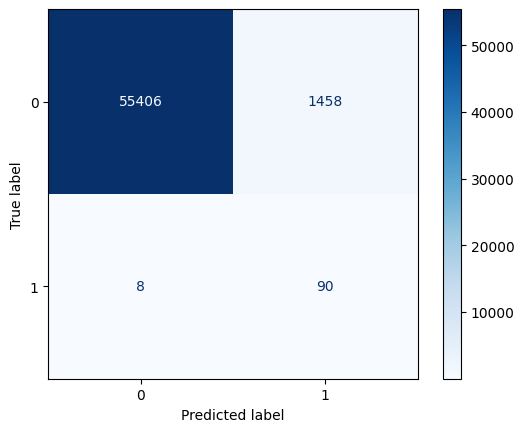

--------------------------------------------------

=== Training DecisionTree ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.34      0.78      0.47        98

    accuracy                           1.00     56962
   macro avg       0.67      0.89      0.74     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.8864625443593306
Confusion Matrix:


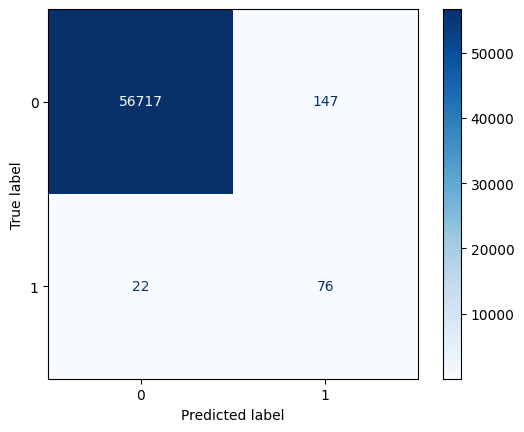

--------------------------------------------------

=== Training RandomForest ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9753984264640014
Confusion Matrix:


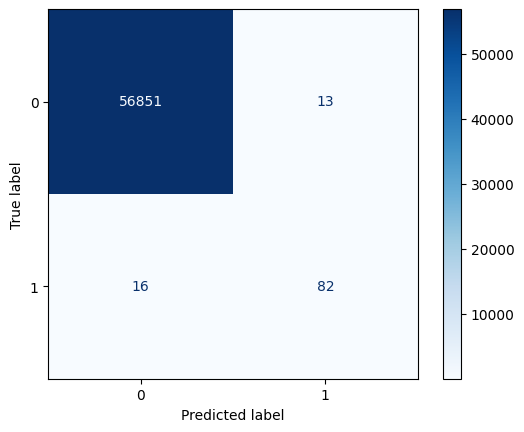

--------------------------------------------------

=== Training XGBoost ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.73      0.89      0.80        98

    accuracy                           1.00     56962
   macro avg       0.87      0.94      0.90     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC: 0.9791588308086319
Confusion Matrix:


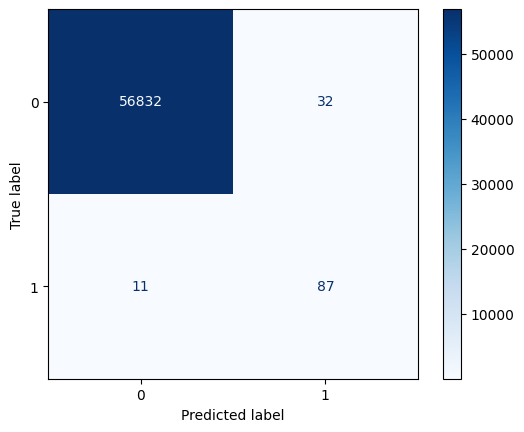

--------------------------------------------------

=== Summary of all models ===


,accuracy,f1_score,precision,recall,roc_auc
LogisticRegression,0.974264,0.109356,0.058140,0.918367,0.969848
DecisionTree,0.997033,0.473520,0.340807,0.775510,0.886463
RandomForest,0.999491,0.849741,0.863158,0.836735,0.975398
XGBoost,0.999245,0.801843,0.731092,0.887755,0.979159


In [22]:
# ✅ Cell 6: Train baseline & advanced models with confusion matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, classification_report, ConfusionMatrixDisplay
)
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
}

trained_models = {}
scores = {}

# Train and evaluate models
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    model.fit(X_train_res, y_train_res)
    trained_models[name] = model
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Metrics
    scores[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else None
    }
    
    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", scores[name]["roc_auc"])
    
    # Confusion matrix plot
    print("Confusion Matrix:")
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.show()
    
    print("-" * 50)

# Summary table
summary_df = pd.DataFrame(scores).T
print("\n=== Summary of all models ===")
display(summary_df)


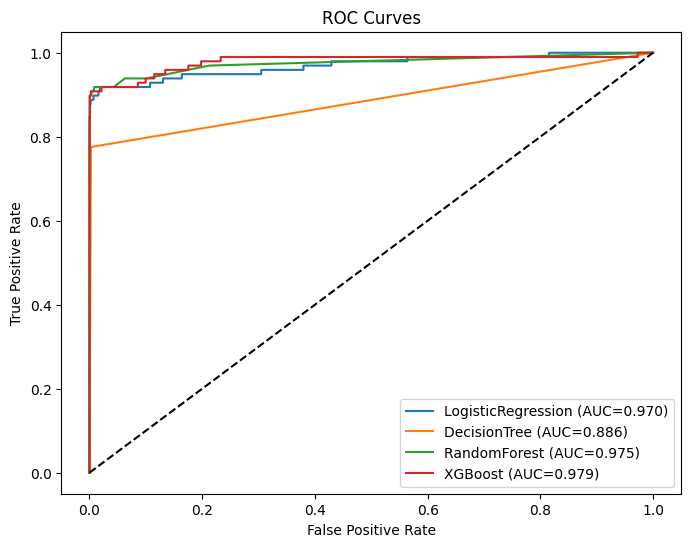

In [9]:
# Cell 7: ROC curves
plt.figure(figsize=(8,6))

for name, model in trained_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_proba):.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


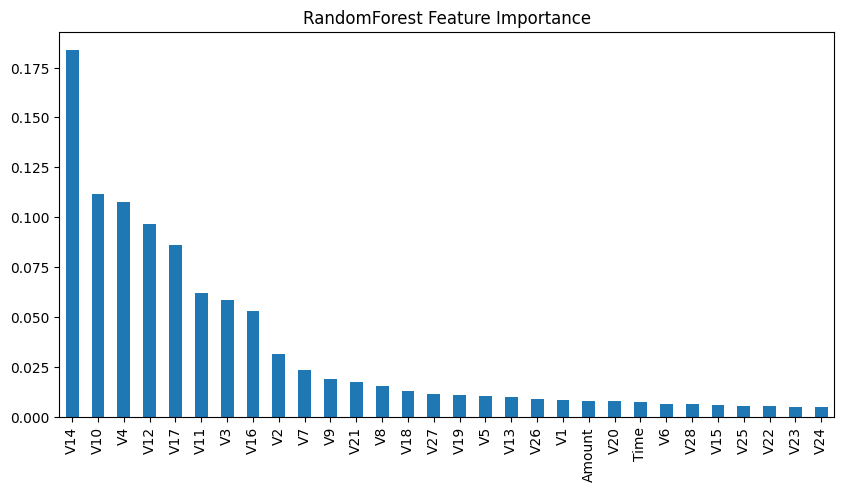

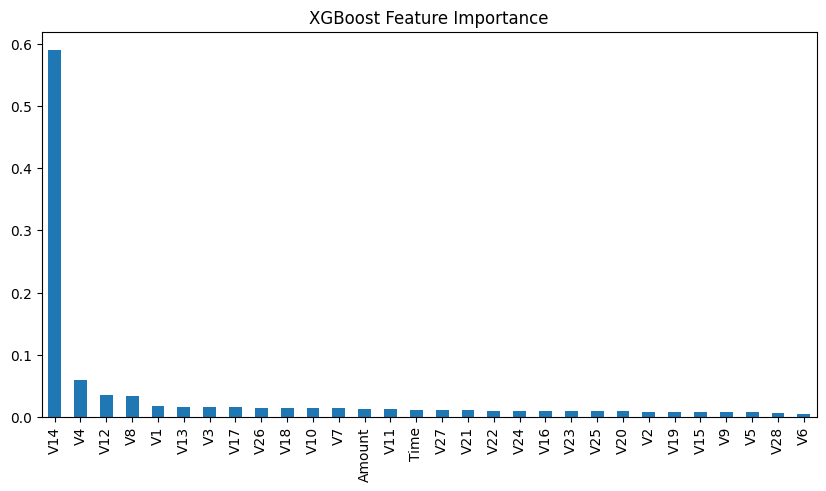

In [10]:
# Cell 8: Feature importance
for name in ["RandomForest","XGBoost"]:
    model = trained_models[name]
    if hasattr(model, "feature_importances_"):
        plt.figure(figsize=(10,5))
        feat_imp = pd.Series(model.feature_importances_, index=X.columns)
        feat_imp.sort_values(ascending=False).plot(kind='bar')
        plt.title(f"{name} Feature Importance")
        plt.show()


In [11]:
# Cell 9: Save trained models
for name, model in trained_models.items():
    joblib.dump(model, f"{name}_fraud_model.pkl")
print("Models saved!")


Models saved!


In [12]:
# Cell 11: Autoencoder (if TensorFlow available)
if TF_AVAILABLE:
    input_dim = X_train_res.shape[1]
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(16, activation='relu')(input_layer)
    encoded = Dense(8, activation='relu')(encoded)
    decoded = Dense(16, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='linear')(decoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    history = autoencoder.fit(X_train_res, X_train_res, epochs=10, batch_size=64, validation_split=0.2)
else:
    print("TensorFlow not installed. Skipping autoencoder.")


Epoch 1/10
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 0.8682 - val_loss: 0.4634
Epoch 2/10
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.4238 - val_loss: 0.3625
Epoch 3/10
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.3711 - val_loss: 0.3341
Epoch 4/10
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.3479 - val_loss: 0.3174
Epoch 5/10
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 0.3307 - val_loss: 0.3111
Epoch 6/10
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 0.3200 - val_loss: 0.3138
Epoch 7/10
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.3142 - val_loss: 0.2961
Epoch 8/10
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.3114 - val_loss: 0.2937
Epoch 9/10
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 0.3095 - val_loss: 0.2857
Epoch 10/10
5687/5687 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.3088 - val_loss: 0.2923


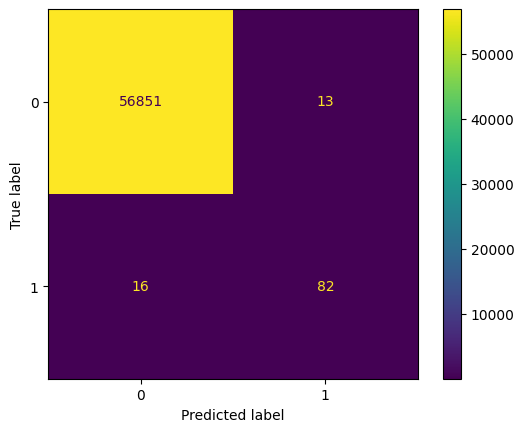

In [13]:
# Cell 12: Confusion Matrix for RandomForest
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(trained_models["RandomForest"], X_test, y_test)
plt.show()

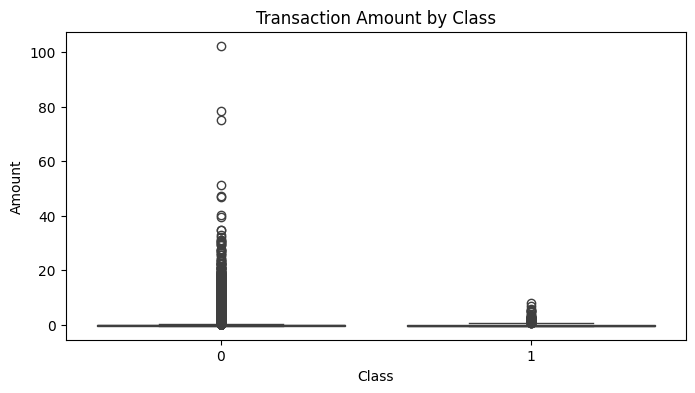

In [14]:
# Cell 13: Fraud amount distribution (fraud vs legit)
plt.figure(figsize=(8,4))
sns.boxplot(x="Class", y="Amount", data=df)
plt.title("Transaction Amount by Class")
plt.show()

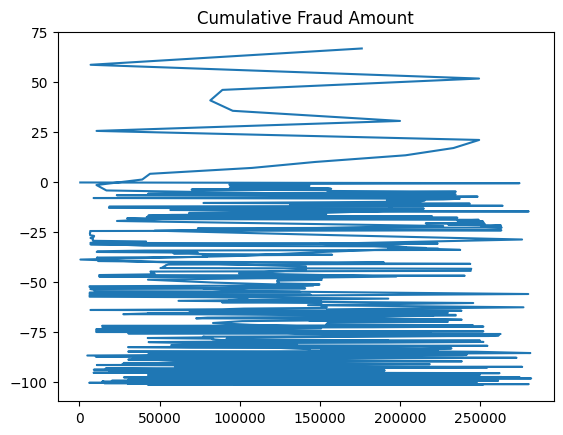

In [15]:
# Cell 14: Cumulative fraud detection rate
fraud = df[df['Class']==1]
plt.plot(np.cumsum(fraud['Amount'].sort_values()), label="Fraud Amount Cumulative")
plt.title("Cumulative Fraud Amount")
plt.show()

In [16]:
# Cell 15: Save Scaler for deployment
joblib.dump(scaler, "scaler_fraud.pkl")

['scaler_fraud.pkl']

In [17]:
# Cell 16: Predict on sample data
sample_pred = trained_models["RandomForest"].predict(X_test[:5])
print("Sample predictions:", sample_pred)

Sample predictions: [0 0 0 0 0]


In [18]:
# Cell 17: Probability predictions
sample_proba = trained_models["RandomForest"].predict_proba(X_test[:5])
print("Sample probabilities:\n", sample_proba)

# Cell 18: Compare all models ROC-AUC in a DataFrame
roc_comparison = pd.DataFrame({k: v["roc_auc"] for k,v in scores.items()}, index=["ROC-AUC"])
display(roc_comparison.T)

Sample probabilities:
 [[1.   0.  ]
 [1.   0.  ]
 [0.98 0.02]
 [1.   0.  ]
 [1.   0.  ]]


,ROC-AUC
LogisticRegression,0.969848
DecisionTree,0.886463
RandomForest,0.975398
XGBoost,0.979159


In [19]:
# Cell 19: Identify top features from RandomForest
top_features = pd.Series(trained_models["RandomForest"].feature_importances_, index=X.columns)
top_features.sort_values(ascending=False).head(10)

V14    0.183722
V10    0.111426
V4     0.107697
V12    0.096527
V17    0.086023
V11    0.062094
V3     0.058454
V16    0.053111
V2     0.031257
V7     0.023408
dtype: float64

In [20]:
# Cell 20: Final message
print("Credit Card Fraud Detection Notebook run complete! ✅")

Credit Card Fraud Detection Notebook run complete! ✅
